In [1]:
import numpy as np
import dlib
import cv2
import imageio
import matplotlib.pyplot as plt


## Load our detector and predictor for facial detection

In [2]:
# create detector and predictor for finding the facial feature
detector = dlib.get_frontal_face_detector()
# pre-trained model: shape_predictor_68_face_landmarks.dat
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## Preprocessing Step: Find landmarks for source image and target image

In [3]:
# convert dlib format bounding box to opencv format bounding box
def rect_to_bb(rect):
    # to the format (x, y, width, height) as we would normally do
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    
    return (x, y, w, h)

# convert detected facial points to np.array format
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)  # only 68 points
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

# detect 68 points of face
def find_68_facial_landmarks(image, detector=detector, predictor=predictor):
    """ 1. Image is a gray scale with value 0-255. Otherwise, the detector won't work
        2. detector and predictor are pre-defined and loaded by dlib"""
    # detect the bounding box of face
    rects = detector(image, 1)
    print(f'bounding box of face: {rects}')
    # rects contains all the bounding boxes for all faces. if only one face, the loop only iterates once.
    for (i, rect) in enumerate(rects):
        # find the facial landmarks, then convert it to a numpy array
        points = predictor(image, rect)
        points = shape_to_np(points)  
            
    return points


def find_triangleList(image, points):
    size = image.shape
    rect = (0, 0, size[1], size[0])  # (x, y, w, h)
    # Create an instance of Subdiv2D
    subdiv = cv2.Subdiv2D(rect)
    for p in points:
        subdiv.insert(tuple(p))
        
    return subdiv.getTriangleList()

In [4]:
# source image
im1 = cv2.imread('christ-pratt.jpg')
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
print(f'Image 1 shape: {im1_gray.shape}')
# detect the bounding box of face
rects = detector(im1_gray, 1)
print(f'Image 1 bounding box of face: {rects}')

# target image
im2 = cv2.imread('kobe-bryant.jpg')
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
print(f'Image 2 shape: {im2_gray.shape}')
# detect the bounding box of face
rects = detector(im2_gray, 1)
print(f'Image 2 bounding box of face: {rects}')

Image 1 shape: (681, 968)
Image 1 bounding box of face: rectangles[[(384, 206) (705, 527)]]
Image 2 shape: (681, 968)
Image 2 bounding box of face: rectangles[[(245, 143) (707, 605)]]


In [5]:
source_points = find_68_facial_landmarks(im1_gray, detector, predictor)
print(f'First five points: \n{source_points[0:5]}')

bounding box of face: rectangles[[(384, 206) (705, 527)]]
First five points: 
[[383 318]
 [386 360]
 [391 403]
 [396 446]
 [410 487]]


In [6]:
target_points = find_68_facial_landmarks(im2_gray, detector,predictor)
print(f'First five points: \n{target_points[0:5]}')

bounding box of face: rectangles[[(245, 143) (707, 605)]]
First five points: 
[[241 275]
 [245 337]
 [250 399]
 [261 459]
 [286 515]]


## Here is What I implemented wrong about finding Delaunay triangluation. 
## However, the final effect is very interesing.
## The correct implementation is following this one

### Add additional points with purpose of including all pixels in the images not just Facial area

In [7]:
# Read array of corresponding points
points1 = source_points.tolist()
points2 = target_points.tolist()
points = []
# Append 8 additional points: 4 corners and 4 half way points
size = im1.shape
h = size[0]
w = size[1]
h2 = int(size[0]/2)
w2 = int(size[1]/2)
points1.append( [0    , 0    ] )
points1.append( [0    , h - 1] )
points1.append( [w - 1, 0    ] )
points1.append( [w - 1, h - 1] )
points1.append( [0    , h2   ] )
points1.append( [w2   , 0    ] )
points1.append( [w - 1, h2   ] )
points1.append( [w2   , h - 1] )

size = im2.shape
h = size[0]
w = size[1]
h2 = int(size[0]/2)
w2 = int(size[1]/2)

points2.append( [0    , 0    ] )
points2.append( [0    , h - 1] )
points2.append( [w - 1, 0    ] )
points2.append( [w - 1, h - 1] )
points2.append( [0    , h2   ] )
points2.append( [w2   , 0    ] )
points2.append( [w - 1, h2   ] )
points2.append( [w2   , h - 1] )

In [8]:
# get the all the triangles: (0,1) as first vertex, (2,3) as second vertex, (4,5) as third vertex
print('Source image:')
source_triangle = find_triangleList(im1,points1)
print(f'Number of triangles: {source_triangle.shape[0]}')
print(f'First 5 triangles defined by points: \n{source_triangle[0:5]}')
print('-------')
print('Target image')
target_triangle = find_triangleList(im2,points2)
print(f'Number of triangles: {target_triangle.shape[0]}')
print(f'First 5 triangles defined by points: \n{target_triangle[0:5]}')

Source image:
Number of triangles: 142
First 5 triangles defined by points: 
[[431. 303. 386. 360. 383. 318.]
 [386. 360. 431. 303. 471. 317.]
 [383. 318.   0.   0. 484.   0.]
 [  0.   0. 383. 318.   0. 340.]
 [383. 318. 484.   0. 456. 283.]]
-------
Target image
Number of triangles: 142
First 5 triangles defined by points: 
[[286. 248. 245. 337. 241. 275.]
 [245. 337. 286. 248. 343. 280.]
 [250. 399.   0. 340. 245. 337.]
 [  0. 340. 250. 399. 261. 459.]
 [241. 275.   0. 340.   0.   0.]]


In [9]:
# Apply affine transform calculated using srcTri and dstTri to src and
def applyAffineTransform(src, srcTri, dstTri, size) :
    # Given a pair of triangles, find the affine transform.
    M = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, M, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, alpha) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask

In [10]:
alpha = 0.5
points = np.zeros((len(points1), 2), dtype=int) 
for i in range(0, points.shape[0]):
    # for x
    points[i,0] = (1-alpha)*points1[i][0] + alpha*points2[i][0]
    # for y
    points[i,1] = (1-alpha)*points1[i][1] + alpha*points2[i][1]

# define our morphed image and its triangles
img_morphed = np.zeros((im1.shape[0], im1.shape[1], 3), dtype = im1.dtype)
morphed_triangle = find_triangleList(img_morphed,points)


N = min(morphed_triangle.shape[0],source_triangle.shape[0],target_triangle.shape[0])
print(N)
for i in range(N):
    source_tri_1 = np.float32([source_triangle[i,0:2],source_triangle[i,2:4],source_triangle[i,4:6]])
    target_tri_1 = np.float32([target_triangle[i,0:2],target_triangle[i,2:4],target_triangle[i,4:6]])
    morphed_tri_1 = np.float32([morphed_triangle[i,0:2],morphed_triangle[i,2:4],morphed_triangle[i,4:6]])


    morphTriangle(im1,im2,img_morphed, source_tri_1, target_tri_1, morphed_tri_1, alpha)

142


(<matplotlib.image.AxesImage at 0x121999358>, Text(0.5, 1.0, 'Alpha = 0.5'))

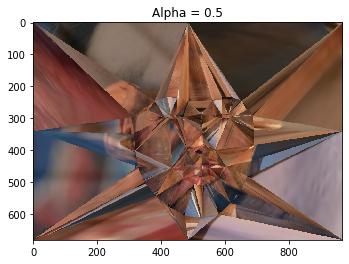

In [11]:
# in order to show color correctly for matplotlib, we need to convert color scheme
show_im = cv2.cvtColor(img_morphed, cv2.COLOR_BGR2RGB)
plt.imshow(show_im), plt.title('Alpha = 0.5')

### As we can see above, it doesn't seem to look good as we have triangles shown in the images.

#### The reason is behind the trangles list.

Let's take a look at the first triangle in the source_trangles.

[431. 303. 386. 360. 383. 318.]

It's defined as [x1,y1, x2,y2, x3,y3]. where x and y are the coordinates on the image

However, We need to store those coordinates' indices in this trangles list

Such as this:

[38 40 37] 
where 38 is the 38th points (points[38]), which contains (x,y), for the first vertex

40 is the 40th points (points[40]), which contains (x,y), for the second vertex

37 is the 37th points (points[37]), which contains (x,y), for the Third vertex

In [12]:
arr = np.linspace(0, 100, 30)
res = []
for (f, a) in enumerate(arr):
    
    alpha = float(a) / 100
    
    points = np.zeros((len(points1), 2), dtype=int) 
    for i in range(0, points.shape[0]):
        # for x
        points[i,0] = (1-alpha)*points1[i][0] + alpha*points2[i][0]
        # for y
        points[i,1] = (1-alpha)*points1[i][1] + alpha*points2[i][1]
        
    morphed_triangle = find_triangleList(img_morphed,points)
    N = min(morphed_triangle.shape[0],source_triangle.shape[0],target_triangle.shape[0])
    # define a morphed image
    img_morphed = np.zeros((im1.shape[0], im1.shape[1], 3), dtype = im1.dtype)
    for i in range(N):
        source_tri_1 = np.float32([source_triangle[i,0:2],source_triangle[i,2:4],source_triangle[i,4:6]])
        target_tri_1 = np.float32([target_triangle[i,0:2],target_triangle[i,2:4],target_triangle[i,4:6]])
        morphed_tri_1 = np.float32([morphed_triangle[i,0:2],morphed_triangle[i,2:4],morphed_triangle[i,4:6]])

        morphTriangle(im1,im2,img_morphed, source_tri_1.tolist(), target_tri_1.tolist(), morphed_tri_1.tolist(), alpha)
        
        
    # Save morphing frame
    index = str(f).zfill(4)
    cv2.imwrite(f'output/output-{index}.png', img_morphed)
    # convert opencv image color BGR to skimage color RGB
    out_im = cv2.cvtColor(img_morphed, cv2.COLOR_BGR2RGB)
    res.append(out_im)
    

    
# # generate gif and mp4
# imageio.mimwrite('output.gif', res)
# imageio.mimwrite('output.mp4', res)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (968, 681) to (976, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [13]:
min(morphed_triangle.shape[0],source_triangle.shape[0],target_triangle.shape[0])

142

## Correct Implementation is below.



In [14]:
# Gets delaunay 2D segmentation and return a list with the the triangles' indexes
def get_delaunay_indexes(image, points) :

    rect = (0, 0, image.shape[1], image.shape[0])
    subdiv = cv2.Subdiv2D(rect);
    for p in points :
        subdiv.insert( tuple(p) )

    triangleList = subdiv.getTriangleList();
    triangles = []
    for p in triangleList:
        vertexes = [0, 0, 0]
        for v in range(3) :
            vv = v * 2
            for i in range(len(points)) :
                if p[vv] == points[i][0] and p[vv+1] == points[i][1] :
                    vertexes[v] = i

        triangles.append(vertexes)

    return triangles

# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, alpha) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))


    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []


    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask
    
# Apply affine transform calculated using srcTri and dstTri to src and
def applyAffineTransform(src, srcTri, dstTri, size) :
    # Given a pair of triangles, find the affine transform.
    M = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine(src, M, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return dst

In [15]:
# Read images
img1 = cv2.imread('christ-pratt.jpg');
img2 = cv2.imread('kobe-bryant.jpg');

# Convert Mat to float data type
img1 = np.float32(img1)
img2 = np.float32(img2)

# Read array of corresponding points
points1 = source_points.tolist()
points2 = target_points.tolist()
# Append 8 additional points: corners and half way points
size = img1.shape
h = size[0]
w = size[1]
h2 = int(size[0]/2)
w2 = int(size[1]/2)
points1.append( [0    , 0    ] )
points1.append( [0    , h - 1] )
points1.append( [w - 1, 0    ] )
points1.append( [w - 1, h - 1] )
points1.append( [0    , h2   ] )
points1.append( [w2   , 0    ] )
points1.append( [w - 1, h2   ] )
points1.append( [w2   , h - 1] )

size = img2.shape
h = size[0]
w = size[1]
h2 = int(size[0]/2)
w2 = int(size[1]/2)

points2.append( [0    , 0    ] )
points2.append( [0    , h - 1] )
points2.append( [w - 1, 0    ] )
points2.append( [w - 1, h - 1] )
points2.append( [0    , h2   ] )
points2.append( [w2   , 0    ] )
points2.append( [w - 1, h2   ] )
points2.append( [w2   , h - 1] )

In [16]:
delaunay = get_delaunay_indexes(img1,points1)
# Alpha values
alpha_values = []
alpha_values = np.linspace(0, 100, 30)  # 30 fps
alpha_values

array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])

### Let's morph!

In [17]:
image_out = []
for (f, a) in enumerate(alpha_values):

    alpha = float(a) / 100
    
    points = []
    # Compute weighted average point coordinates for morphed image
    for i in range(0, len(points1)):
        x = ( 1 - alpha ) * points1[i][0] + alpha * points2[i][0]
        y = ( 1 - alpha ) * points1[i][1] + alpha * points2[i][1]
        points.append((x,y))

    # initialize output image
    imgMorph = np.zeros(img1.shape, dtype = img1.dtype)

    for v1, v2, v3 in delaunay :
        t1 = [points1[v1], points1[v2], points1[v3]]
        t2 = [points2[v1], points2[v2], points2[v3]]
        t  = [ points[v1],  points[v2],  points[v3]]

        # Morph one triangle at a time.
        morphTriangle(img1, img2, imgMorph, t1, t2, t, alpha)


    # Save morphing frame
    index = str(f).zfill(4)
    cv2.imwrite(f'output2/output-{index}.png', np.uint8(imgMorph))
    
    # Save frame into a sequence
    # convert opencv image color BGR to skimage color RGB
    out_im = cv2.cvtColor(np.uint8(imgMorph), cv2.COLOR_BGR2RGB)
    image_out.append(out_im)
    
    
# generate gif and mp4
imageio.mimwrite('output2.gif', image_out)
imageio.mimwrite('output2.mp4', image_out)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (968, 681) to (976, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### show result when alpha = 0.5

alpha = 0.5


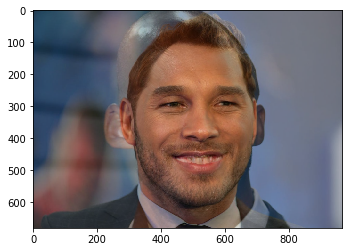

In [18]:
alpha = 0.5

points = []
# Compute weighted average point coordinates for morphed image
for i in range(0, len(points1)):
    x = ( 1 - alpha ) * points1[i][0] + alpha * points2[i][0]
    y = ( 1 - alpha ) * points1[i][1] + alpha * points2[i][1]
    points.append((x,y))

# initialize output image
imgMorph = np.zeros(img1.shape, dtype = img1.dtype)

for v1, v2, v3 in delaunay :
    t1 = [points1[v1], points1[v2], points1[v3]]
    t2 = [points2[v1], points2[v2], points2[v3]]
    t  = [ points[v1],  points[v2],  points[v3]]

    # Morph one triangle at a time.
    morphTriangle(img1, img2, imgMorph, t1, t2, t, alpha)



# Save frame into a sequence
# convert opencv image color BGR to skimage color RGB
out_im = cv2.cvtColor(np.uint8(imgMorph), cv2.COLOR_BGR2RGB)
plt.imshow(out_im)
print('alpha = 0.5')

(<matplotlib.image.AxesImage at 0x1228b6908>, Text(0.5, 1.0, 'Alpha = 1'))

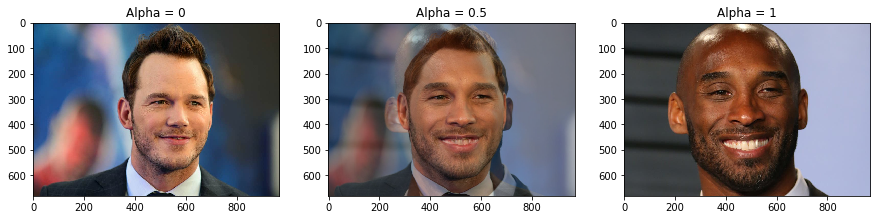

In [19]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)), plt.title('Alpha = 0')
plt.subplot(1,3,2)
plt.imshow(out_im), plt.title('Alpha = 0.5')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)), plt.title('Alpha = 1')